<a id="inicio"></a>
## REGRESSÃO

Esse notebook contém um projeto com modelo de regressão. O objetivo principal é tentar prever os preços de carros.

Vamos começar lendo os dados.

In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

In [ ]:
cars_df = pd.read_csv('OLX_Car_Data.csv', encoding = 'unicode_escape')
cars_df.describe(include='all')

,Brand,Condition,Fuel,KMs Driven,Model,Price,Registered City,Transaction Type,Year
count,22836,22837,22528,2.268700e+04,22525,2.497300e+04,20337,22528,22689.000000
unique,23,2,5,NaN,303,NaN,61,2,NaN
top,Suzuki,Used,Petrol,NaN,Cultus VXR,NaN,Karachi,Cash,NaN
freq,9773,18472,14309,NaN,1775,NaN,16599,21513,NaN
mean,NaN,NaN,NaN,1.278112e+05,NaN,9.128953e+05,NaN,NaN,2005.901626
std,NaN,NaN,NaN,5.996726e+05,NaN,1.537134e+06,NaN,NaN,9.563804
min,NaN,NaN,NaN,1.000000e+00,NaN,5.000000e+04,NaN,NaN,1915.000000
25%,NaN,NaN,NaN,1.600000e+04,NaN,3.800000e+05,NaN,NaN,2002.000000
50%,NaN,NaN,NaN,6.651000e+04,NaN,6.500000e+05,NaN,NaN,2008.000000
75%,NaN,NaN,NaN,1.000000e+05,NaN,1.145000e+06,NaN,NaN,2013.000000


Como os nomes dascolunas apresentam espaços, vamos renomear as colunas para remover os espaços:

In [ ]:
cars_df.rename(columns = {'KMs Driven':'KMs_Driven',
                          'Registered City':'Registered_City',
                          'Transaction Type':'Transaction_Type'},
               inplace = True)

Quando utilizamos o método ```describe``` conseguimos ver algumas informações necessárias para fazer uma limpeza básica nos nossos dados.

Antes disso, vamos iniciar visualizando a quantidade de cada modelo de carro vendido na OLX.

In [ ]:
cars_df['Model'].value_counts()

Cultus VXR       1775
Alto             1658
Corolla GLI      1043
Mehran VX        1025
Other             920
                 ... 
LX Series           1
808                 1
Luce                1
cars-other-37       1
Shehzore            1
Name: Model, Length: 303, dtype: int64

Já que a coluna Model tem muitas categorias, vamos nomear todas com menos de 400 observações de 'Outros' e remover o valores nulos:

In [ ]:
sorted(cars_df['Model'].value_counts()[cars_df['Model'].value_counts()>400].index)

['Alto',
 'Bolan',
 'Charade',
 'City IVTEC',
 'Civic EXi',
 'Civic VTi Oriel Prosmatec',
 'Corolla GLI',
 'Corolla XLI',
 'Cultus VXR',
 'Cuore',
 'Khyber',
 'Mehran VX',
 'Mehran VXR',
 'Mira',
 'Other',
 'Vitz']

In [ ]:
models = ['Alto',
  'Bolan',
  'Charade',
  'City IVTEC',
  'Civic EXi',
  'Civic VTi Oriel Prosmatec',
  'Corolla GLI',
  'Corolla XLI',
  'Cultus VXR',
  'Cuore',
  'Khyber',
  'Mehran VX',
  'Mehran VXR',
  'Mira',
  'Vitz'
]

cars_df.loc[~cars_df['Model'].isin(models),'Model'] = 'Outros'

cars_df.dropna(axis=0, inplace=True)

Os outiliers mostram que existem dados muito distantes dos dados que mais aparecem. A distância interquartil é a distância entre Q1 (primeiro quartil) e Q3 (terceiro quartil). Para saber os outliers temos Q1 - 1.5IQR e Q3 + 1.5IQR.

Para remover os outliers:

In [ ]:
low = 0.05
high = 0.95
quant_df = cars_df.quantile([low, high])
cars_df = cars_df[(cars_df.KMs_Driven < quant_df.loc[high, "KMs_Driven"]) &
                  (cars_df.KMs_Driven > quant_df.loc[low, "KMs_Driven"]) &
                  (cars_df.Price < quant_df.loc[high, "Price"]) &
                  (cars_df.Price > quant_df.loc[low, "Price"]) &
                  (cars_df.Year < quant_df.loc[high, "Year"]) &
                  (cars_df.Year > quant_df.loc[low, "Year"])]

Sabemos que algumascolunas possuem valores binários, dessa forma, transformaremos elas:


In [ ]:
cars_df['is_new'] = 1
cars_df.loc[cars_df.Condition == 'Used', 'is_new'] = 0
cars_df.drop(['Condition'], axis=1, inplace=True)

cars_df['is_cash'] = 0
cars_df.loc[cars_df.Transaction_Type=='Cash', 'is_cash'] = 1
cars_df.drop('Transaction_Type', axis=1, inplace=True)

Com as outras colunas utilizaremos a técnica do One Hot Encoding.

Rótulos numéricos, no entanto, implicam que as categorias têm relações entre si, como uma ser menor ou ser seguida por outra. Para resolver isso, uma transformação quase sempre feita em dados categóricos é a chamada One Hot Encoding.

O que ela faz é criar uma coluna/variável numérica para cada categoria, com os valores 0 ou 1 representando a presença dessa categoria para cada registro.



In [ ]:
cars_df = pd.concat([cars_df.drop("Brand", axis=1), pd.get_dummies(cars_df.Brand, prefix='Brand')], axis=1)
cars_df = pd.concat([cars_df.drop("Fuel", axis=1), pd.get_dummies(cars_df.Fuel, prefix='Fuel')], axis=1)
cars_df = pd.concat([cars_df.drop("Registered_City", axis=1), pd.get_dummies(cars_df.Registered_City, prefix='RCity')], axis=1)
cars_df = pd.concat([cars_df.drop("Model", axis=1), pd.get_dummies(cars_df.Model, prefix='Model')], axis=1)

cars_df.describe(include='all')

,KMs_Driven,Price,Year,is_new,is_cash,Brand_Audi,Brand_BMW,Brand_Changan,Brand_Chevrolet,Brand_Classic & Antiques,...,Model_Corolla GLI,Model_Corolla XLI,Model_Cultus VXR,Model_Cuore,Model_Khyber,Model_Mehran VX,Model_Mehran VXR,Model_Mira,Model_Outros,Model_Vitz
count,14498.000000,1.449800e+04,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,...,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000,14498.000000
mean,76730.142847,7.807886e+05,2006.757622,0.139743,0.972824,0.000345,0.000828,0.000345,0.002621,0.000069,...,0.050697,0.029452,0.102980,0.030211,0.026279,0.049041,0.038626,0.028280,0.422265,0.031522
std,48129.383137,4.369079e+05,6.702141,0.346733,0.162602,0.018568,0.028759,0.018568,0.051131,0.008305,...,0.219385,0.169077,0.303943,0.171174,0.159971,0.215962,0.192709,0.165777,0.493937,0.174729
min,2.000000,1.550000e+05,1987.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,44000.000000,4.450000e+05,2004.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,77000.000000,6.800000e+05,2008.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,100000.000000,1.060000e+06,2012.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,222211.000000,2.055000e+06,2016.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Como nossa coluna alvo é o preço, dado que queremos realizar um predição deste valor, iremos retirar essa coluna.

In [ ]:
y, X = cars_df.Price, cars_df.drop('Price', axis=1)

print("X", X.shape)
print("y", y.shape)

X (14498, 102)
y (14498,)


Agora separaremos em treino, validação e teste:


In [ ]:
seed = 1

# separando treino e teste
X_training, X_test, y_training, y_test = train_test_split(X, y, random_state=seed, test_size=0.25) #, stratify=y)
print("Test set X", X_test.shape)
print("Test set y", y_test.shape)

# separando treino e validação
X_train, X_val, y_train, y_val = train_test_split(X_training, y_training, random_state=seed,
                                                  test_size=0.33) #, stratify=y_training)

print("Train set X", X_train.shape)
print("Train set y", y_train.shape)
print("Validation set X", X_val.shape)
print("Validation set y", y_val.shape)

Test set X (3625, 102)
Test set y (3625,)
Train set X (7284, 102)
Train set y (7284,)
Validation set X (3589, 102)
Validation set y (3589,)


## Modelagem

Agora partiremos para a segunda etapa de nosso projeto, o treinamento dos modelos.



#### Random Forest

Vamos iniciar treinando um modelo de *random forest* com validação cruzada e *grid search*. O *grid search* deve variar, pelo menos, os parâmetros *n_estimators* e *max_depth*, mas você pode incluir outros.

Após o treino, criaremos o *dataframe* ```cv_results``` com os resultados de cada iteração e o dicionário ```cv_best_params``` com os valores da melhor combinação de parâmetros.

In [ ]:
# Random Forest com validação cruzada e Grid Search

# definindo os valores possíveis dos parâmetros a serem testados
params = {'n_estimators': [5, 50, 100, 250, 500],
          'max_depth': [2, 5, 10, 25, 50]}

# criando o objeto do modelo com RandomForestRegressor
rf_model_cv_gs = RandomForestRegressor(random_state = seed)

# criando o objeto do grid search com GridSearchCV
grid_search = GridSearchCV(rf_model_cv_gs, param_grid=params, return_train_score=True, scoring='neg_root_mean_squared_error')

# treinando o modelo com o grid search
grid_search.fit(X_training, y_training) #por ser validação cruzada usamos o _training

# pegando os resultados da validação cruzada (cv_results)
cv_results = pd.DataFrame(grid_search.cv_results_)

# pegando e imprimindo a melhor combinação de hiperparâmetros
cv_best_params = grid_search.best_params_
print('\n Best hyperparameters:')
print(cv_best_params)


 Best hyperparameters:
{'max_depth': 10, 'n_estimators': 250}


Agora, treinaremos o modelo final de *random forest* com os melhores parâmetros obtidos no *grid search* visto anteriormente.

In [ ]:
# imprimindo o score médio nas bases de treino
print("Average accuracy on train set: {:.3f} +/- {:.3f}".format(cv_results[cv_results.rank_test_score == 1].mean_train_score.values[0],
                                                                     cv_results[cv_results.rank_test_score == 1].std_train_score.values[0]))
# imprimindo o score médio nas bases de validação
print("Average accuracy on validation set: {:.3f} +/- {:.3f}".format(cv_results[cv_results.rank_test_score == 1].mean_test_score.values[0],
                                                                     cv_results[cv_results.rank_test_score == 1].std_test_score.values[0]))

# configurando o modelo com a melhor combinação de hiperparâmetros
rf_model_cv_gs.set_params(n_estimators = cv_best_params['n_estimators'],
                        max_depth = cv_best_params['max_depth'])

# treinando um modelo com a melhor combinação de hiperparâmetros
rf_model_cv_gs.fit(X_training, y_training)
best_model_params = rf_model_cv_gs.get_params()

Average accuracy on train set: -139346.256 +/- 480.623
Average accuracy on validation set: -171183.112 +/- 3920.224


Vamos obter um *dataframe* com a importância de cada variável do modelo de *random forest*.

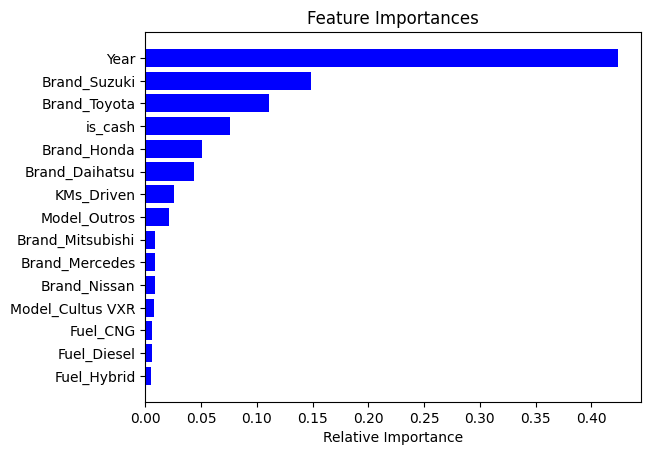

In [ ]:
# desenhando o gráfico de impoartância de variáveis
features = X_training.columns
importances = rf_model_cv_gs.feature_importances_
indices = np.argsort(importances)

feature_importances_df = pd.DataFrame({'features': features,
                                       'importances': importances})

plt.title('Feature Importances')
plt.barh(range(len(importances[indices][-15:])), importances[indices][-15:], color='b', align='center')
plt.yticks(range(len(importances[indices][-15:])), [features[i] for i in indices[-15:]])
plt.xlabel('Relative Importance')
plt.show()

Por fim, vamos calcular o RMSE do modelo de *random forest* final na base de teste.

In [ ]:
y_test_pred_rf = rf_model_cv_gs.predict(X_test)
rmse_test_rf = math.sqrt(mean_squared_error(y_test, y_test_pred_rf))
print(rmse_test_rf)

166497.11451958114


#### Light GBM

Seguindo a mesma lógica, vamos treinar um modelo de Light GBM com validação cruzada e grid search. O grid search deve variar, pelo menos, os parâmetros learning_rate e n_estimators, mas você pode incluir outros.

Após o treino, crie o dataframe cv_results com os resultados de cada iteração e o dicionário cv_best_params com os valores da melhor combinação de parâmetros.

In [ ]:
import sys
!{sys.executable} -m pip install lightgbm

In [ ]:
import lightgbm as lgb
import logging

# Defina o nível de registro para exibir apenas mensagens de aviso (WARNING) ou mais graves
logging.getLogger('lightgbm').setLevel(logging.WARNING)

In [ ]:
# Light GBM com validação cruzada e Grid Search

# definindo os valores possíveis dos parâmetros a serem testados

# params = {'max_depth': [10, 50, 100],
#           'learning_rate': [0.01, 0.03, 0.1, 0.5],
#           'num_iterations': [100, 200, 500],
#           'min_data_in_leaf': [20, 50],
#           'min_gain_to_split': [0., 1, 5]}

params = {'learning_rate': [0.01, 0.03, 0.1, 0.5],
          'n_estimators': [5, 50, 100, 250, 500]} #que pode ser chamado de n_estimators

# criando o objeto do modelo com XGBClassifier
lgb_model_cv_gs = lgb.LGBMRegressor(random_state = seed)

# criando o objeto do grid search com GridSearchCV
grid_search = GridSearchCV(lgb_model_cv_gs, param_grid=params, return_train_score=True, scoring='neg_root_mean_squared_error')

# treinando o modelo com o grid search
grid_search.fit(X_training, y_training)

# pegando os resultados da validação cruzada (cv_results)
cv_results = pd.DataFrame(grid_search.cv_results_)

# pegando e imprimindo a melhor combinação de hiperparâmetros
cv_best_params = grid_search.best_params_
print('\n Best hyperparameters:')
print(cv_best_params)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 8698, number of used features: 43
[LightGBM] [Info] Start training from score 780791.088296
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 371
[LightGBM] [Info] Number of data points in the train set: 8698, number of used features: 45
[LightGBM] [Info] Start training from score 781929.474017
[LightGBM] [Warn

Agora, vamos treinar o modelo final de *light GBM* com os melhores parâmetros obtidos no *grid search* do exercício anterior.

In [ ]:
# imprimindo o score médio nas bases de treino
print("Average accuracy on train set: {:.3f} +/- {:.3f}".format(cv_results[cv_results.rank_test_score == 1].mean_train_score.values[0],
                                                                     cv_results[cv_results.rank_test_score == 1].std_train_score.values[0]))

# imprimindo o score médio nas bases de validação
print("Average accuracy on validation set: {:.3f} +/- {:.3f}".format(cv_results[cv_results.rank_test_score == 1].mean_test_score.values[0],
                                                                     cv_results[cv_results.rank_test_score == 1].std_test_score.values[0]))

# configurando o modelo com a melhor combinação de hiperparâmetros
lgb_model_cv_gs.set_params(learning_rate = cv_best_params['learning_rate'],
                           n_estimators = cv_best_params['n_estimators'])

# treinando um modelo com a melhor combinação de hiperparâmetros
lgb_model_cv_gs.fit(X_training, y_training)
best_model_params = lgb_model_cv_gs.get_params()

Average accuracy on train set: -143515.902 +/- 1756.022
Average accuracy on validation set: -168155.148 +/- 5350.408
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 372
[LightGBM] [Info] Number of data points in the train set: 10873, number of used features: 45
[LightGBM] [Info] Start training from score 781117.065115


Vamos obter um *dataframe* com a importância de cada variável do modelo de *light GBM*.

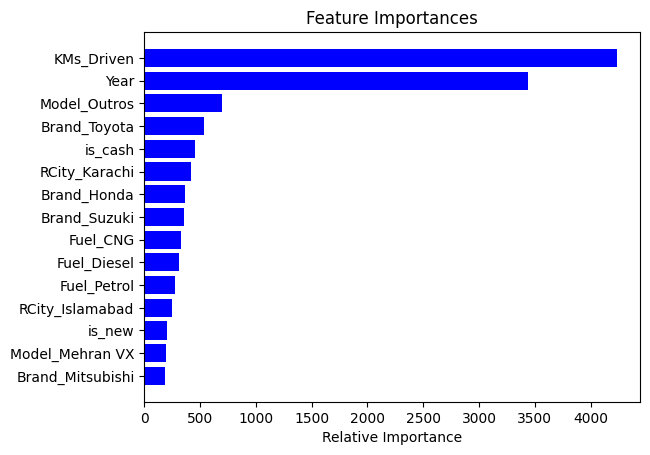

In [ ]:
# desenhando o gráfico de importância de variáveis
features = X_training.columns
importances = lgb_model_cv_gs.feature_importances_
indices = np.argsort(importances)

feature_importances_df = pd.DataFrame({'features': features,
                                       'importances': importances})

plt.title('Feature Importances')
plt.barh(range(len(importances[indices][-15:])), importances[indices][-15:], color='b', align='center')
plt.yticks(range(len(importances[indices][-15:])), [features[i] for i in indices[-15:]])
plt.xlabel('Relative Importance')
plt.show()

Por fim, vamos calcular o RMSE do modelo de *light GBM* final na base de teste.

In [ ]:
y_test_pred_lgb = lgb_model_cv_gs.predict(X_test)
rmse_test_lgb = math.sqrt(mean_squared_error(y_test, y_test_pred_lgb))
print(rmse_test_lgb)

162021.62719906186


#### Comparações

Vamos desenhar gráficos para comparar as duas previsões como fizamos com os dados e usá-los para responder as demais perguntas:

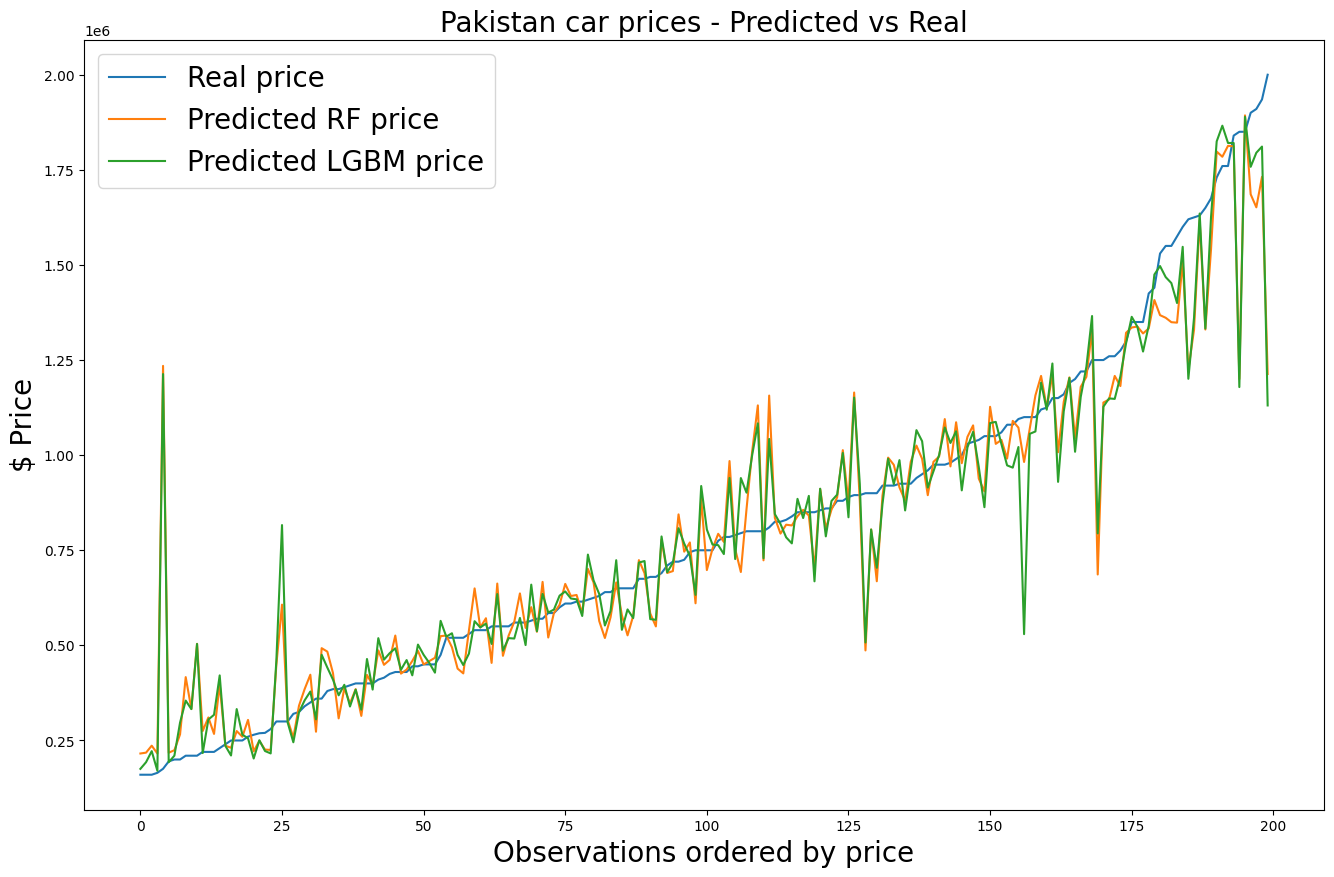

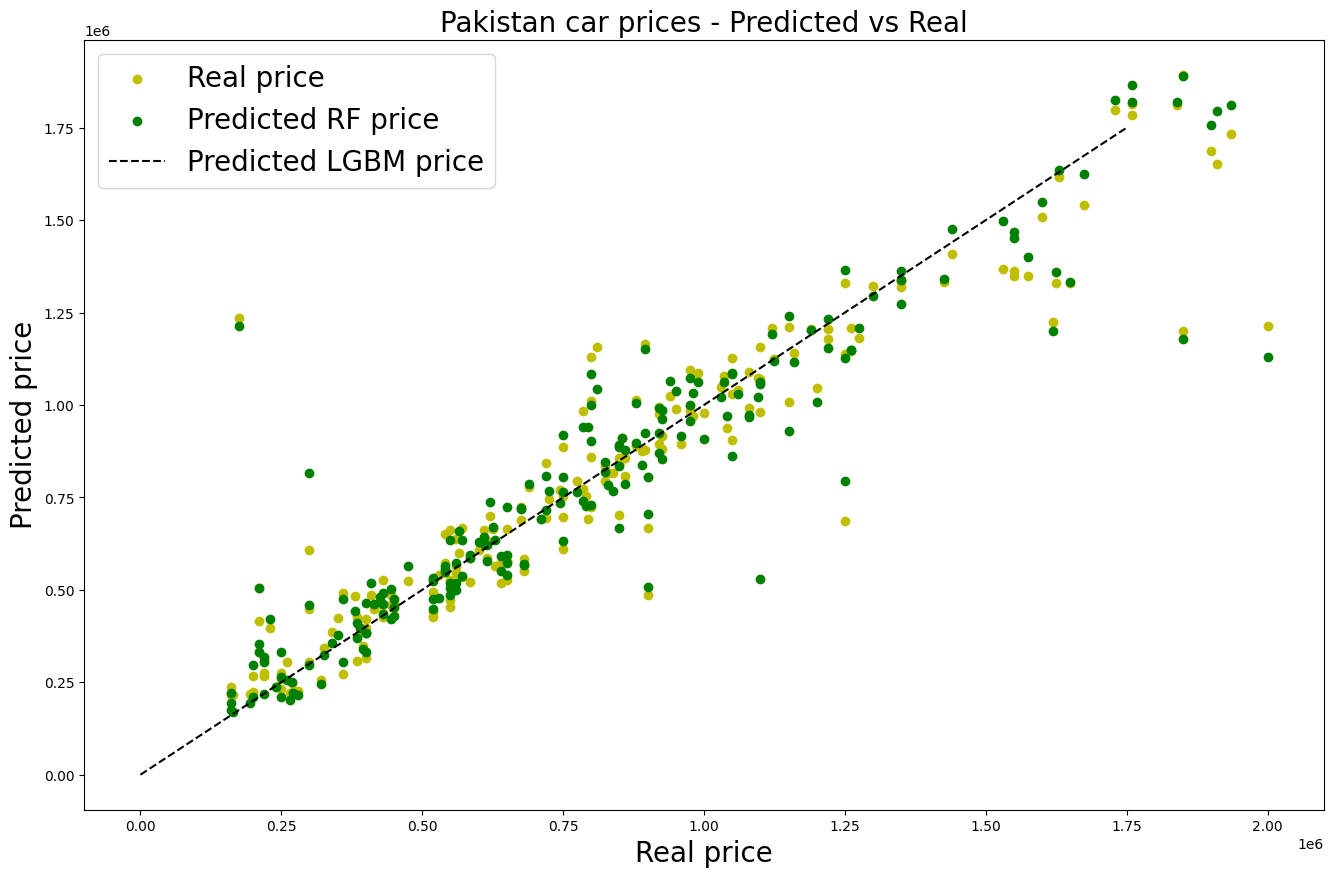

In [ ]:
# Desenhando o gráfico de valores previstos por valores reais para ambos os modelos

plt.figure(figsize=(16,10))
plt.title('Pakistan car prices - Predicted vs Real',fontsize=20)
df = pd.DataFrame({'real':y_val,'Random Forest':rf_model_cv_gs.predict(X_val),
                   'LGBM':lgb_model_cv_gs.predict(X_val)})
df = df.sample(200)
df.sort_values(by=['real'],ascending=True,inplace=True)
df = df.reset_index(drop=True)
plt.plot(df)
plt.legend(['Real price','Predicted RF price','Predicted LGBM price'],fontsize=20)
plt.ylabel('$ Price',fontsize=20)
plt.xlabel('Observations ordered by price',fontsize=20)
plt.show()

plt.figure(figsize=(16,10))
plt.title('Pakistan car prices - Predicted vs Real',fontsize=20)
plt.scatter(x=df['real'],y=df['Random Forest'],c='y')
plt.scatter(x=df['real'],y=df['LGBM'],c='g')
plt.plot([0,1750000],[0,1750000],'k--')
# plt.axis([0,1750000,0,1750000])
plt.legend(['Real price','Predicted RF price','Predicted LGBM price'],fontsize=20)
plt.xlabel('Real price',fontsize=20)
plt.ylabel('Predicted price',fontsize=20)
plt.show()